In [1]:
import sys
import random
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
import ipyvolume as ipv
from matplotlib import pyplot

from operator import mul


from IPython.display import Image
from scipy import optimize


from tyssue import config, Sheet, SheetGeometry, History, EventManager
from tyssue import SheetGeometry as geom
from tyssue import PlanarGeometry as geom
from tyssue.draw.plt_draw import create_gif
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5
import copy

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model


from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

import warnings
warnings.filterwarnings('ignore')

C++ extension are not available for this version
collision solver could not be imported You may need to install CGAL and re-install tyssue


In [2]:
def length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity):
    for edge in range(len(cellmap.edge_df)):
        FRCnewValue = random.randrange(FRC_lower_length_elasticity, FRC_higher_length_elasticity)/10000
        ECMnewValue = random.randrange(ECM_lower_length_elasticity, ECM_higher_length_elasticity)/10000
        cellmap.edge_df['length_elasticity'][edge] = FRCnewValue + ECMnewValue
    return cellmap

In [3]:
def prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area):
    for face in range(len(cellmap.face_df)):
        newValue = random.randrange(lower_prefered_area, higher_prefered_area)/10000
        cellmap.face_df['prefered_area'][face] = newValue
    return cellmap

In [4]:
def change_specs(cellmap_original, geom_original, model_original, history_original, face_elasticity,
                 lower_prefered_area, higher_prefered_area, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity,
                 ECM_higher_length_elasticity, line_nought, endTime):
    
    
    cellmap_original = length_elasticity_range(cellmap_original, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity)
    cellmap_original = prefered_area_range(cellmap_original, lower_prefered_area, higher_prefered_area)


    
    cellmap_original.face_df["face_elasticity"] = face_elasticity
    cellmap_original.edge_df["prefered_length"] = line_nought

    cellmap_original.vert_df["viscosity"] = 1   
    
    #cellmap_original.face_df["prefered_area"][0] = 2
    #cellmap_original.face_df["prefered_area"][41] = 2
    

    solver1 = EulerSolver(cellmap_original, geom_original, model_original, history=history_original, auto_reconnect=True)
    res1 = solver1.solve(tf=endTime, dt=0.05)
    
    history_original.record(time_stamp = endTime)
    
    cellmap_new = copy.deepcopy(cellmap_original)
    geom_new = copy.deepcopy(geom_original)
    model_new = copy.deepcopy(model_original)
    history_new = copy.deepcopy(history_original)
    
    return [cellmap_new, geom_new, model_new, history_new]
    

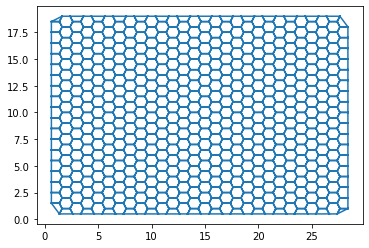

In [5]:
## Definition of the sheet
geom_original  = SheetGeometry 
model_original = model_factory([    
    effectors.FaceAreaElasticity,
    effectors.LengthElasticity
    ])

cellmap_original = Sheet.planar_sheet_3d('cellmap', 20, 30, 1, 1) # This may need to change

history_original = History(cellmap_original,
                           extra_cols={"edge":["dx", "dy"]})


cellmap_original.sanitize ( trim_borders=True, order_edges=True )

geom.update_all(cellmap_original)

cellmap_original.update_specs(model_original.specs)

fig, ax = sheet_view(cellmap_original, ['y', 'x'], mode='quick')

In [6]:
print('Faces associated with the first edges:')
print(cellmap_original.edge_df['face'])
print('\n')

Faces associated with the first edges:
edge
0         0
1         0
2         0
3         0
4         1
       ... 
3091    530
3092    531
3093    531
3094    531
3095    531
Name: face, Length: 3096, dtype: int64




## Phase: Homeostasis

In [7]:
[cellmap_H, geom_H, model_H, history_H] = change_specs(cellmap_original, geom_original, model_original, history_original, face_elasticity = 0.05, lower_prefered_area = 1, higher_prefered_area = 15000,     
                                                       FRC_lower_length_elasticity = 100, FRC_higher_length_elasticity = 500, ECM_lower_length_elasticity = 1000, 
                                                       ECM_higher_length_elasticity = 5000, line_nought = 0.002 , endTime = 5)


face
0      0.312674
1      0.492365
2      0.701034
3      0.610651
4      0.292802
         ...   
527    0.855684
528    0.259014
529    0.228644
530    0.389812
531    0.151813
Name: area, Length: 532, dtype: float64


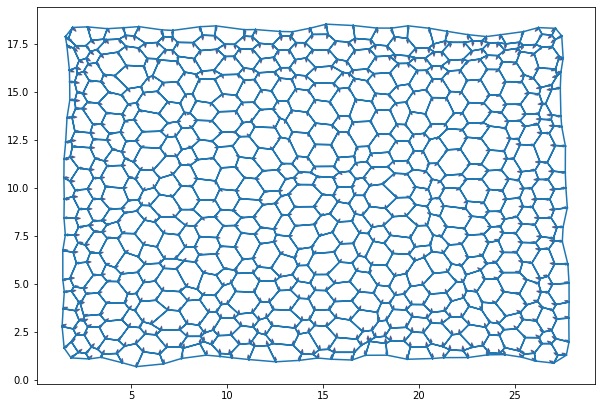

In [8]:
fig, ax = plot_forces(cellmap_H, geom_H, model_H, ['y', 'x'], 1)
fig.set_size_inches(10, 10)

print(cellmap_H.face_df["area"])

In [9]:
#fig, ax = sheet_view(cellmap_H, ['y', 'x'])
#fig.set_size_inches(15, 15)

#for face, data in cellmap_original.face_df.iterrows():
#    ax.text(data.y, data.x, face, fontsize=7, color="r")

(array([ 5.,  8., 10., 12., 24., 27., 43., 57., 45., 33., 44., 46., 27.,
        47., 31., 27., 22., 16.,  5.,  3.]),
 array([ 1.        ,  2.40751866,  3.81503732,  5.22255598,  6.63007463,
         8.03759329,  9.44511195, 10.85263061, 12.26014927, 13.66766793,
        15.07518659, 16.48270525, 17.8902239 , 19.29774256, 20.70526122,
        22.11277988, 23.52029854, 24.9278172 , 26.33533586, 27.74285451,
        29.15037317]),
 <BarContainer object of 20 artists>)

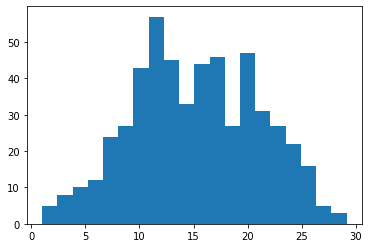

In [10]:
normalised_area_df = cellmap_H.face_df["area"] / min(cellmap_H.face_df["area"])
plt.hist(normalised_area_df, bins = 20)

## Phase: Expansion

In [11]:
endTime = 5

#for face in range(len(cellmap_H.face_df)):
current_prefered_area = cellmap_H.face_df['prefered_area']
cellmap_H.update_specs(
{"face": {"prefered_area": 2*current_prefered_area}},
reset=True)
current_length_elasticity = cellmap_H.edge_df['length_elasticity']
cellmap_H.update_specs(
{"edge": {"length_elasticity": 0.05*current_length_elasticity}},
reset=True)
    
solver1 = EulerSolver(cellmap_H, geom_H, model_H, history=history_H, auto_reconnect=True)
res1 = solver1.solve(tf=endTime, dt=0.05)

history_original.record(time_stamp = endTime)

cellmap_new = copy.deepcopy(cellmap_H)
geom_new = copy.deepcopy(geom_H)
model_new = copy.deepcopy(model_H)
history_new = copy.deepcopy(history_H)

#cellmap_H.face_df.loc[cellmap_H.face_df['area']>0.5, 'prefered_area'] = 1
#cellmap_H.face_df.loc[cellmap_H.face_df['area']<0.5, 'prefered_area'] = 0.5
#geom.update_all(cellmap_H)


#It's updating specs but not solving the system?

Reseting column prefered_area of the face dataset with new specs
Reseting column length_elasticity of the edge dataset with new specs


In [12]:
history = History(solver1.history.sheet)
history.browse()

AttributeError: 'History' object has no attribute 'browse'

In [ ]:
fig, ax = sheet_view(solver1.history.retrieve(10), ['y', 'x'])
fig.set_size_inches(15, 15)

cellmap_Try = solver1.history.retrieve(10)
print(cellmap_Try.face_df["prefered_area"])

In [ ]:
fig, ax = plot_forces(cellmap_new, geom_new, model_new, ['y', 'x'], 1)
fig.set_size_inches(10, 10)

print(cellmap_new.face_df["prefered_area"])


## Phase Proliferation

## Phase: Critical

In [ ]:
[cellmap_Tc, geom_Tc, model_Tc, history_Tc] = change_specs(cellmap_Te, geom_Te, model_Te, history_Te, 5, 10, 0.0002, 30)
fig, ax = plot_forces(cellmap_Te, geom_Te, model_Te, ['x', 'y'], 1)
print(cellmap_Te.face_df["area"].mean())
#plt.savefig("T_homeostasis.pdf", format="pdf", bbox_inches="tight")